# SENTIMENT ANALYSIS OF ANDROID BANKING APP REVIEWS
CSDA1040 - Advanced Methods of Data Analysis, York University, Canada <br>
Created by: Jessee Ho
***

## INTRODUCTION

Sentiment analysis is a NLP technique that tries to extract and interpret the sentiment or emotion of raw text. In this scenario, I will be applying this technique to customer reviews of banking apps on the Google Play store. The goal of this study is to identify what customers like or dislike about these apps. A Random Forest Classifier model is used to predict the sentiment of neutral reviews.

## RESULT SUMMARY

The trained random forest classification model had an accuracy of 87%, precision of 88%, recall of 87% and average cross validated ROC AUC of 94% indicating a relatively good model. The most important features were the 4 sentiment scores (positive, compound, neutral and negative), word and character counts, a few document vectors, and the words great and easy (from TD-IDF). The model was then applied to the neutral reviews to try and categorize the review into positive or negative. <br>

Customers liked a banking app that can offer the same services as in-person banking and online banking. Some key functions that users enjoyed were mobile cheque deposits, account balance transfers, bill payment and the capability to view credit card transactions. <br>

Customer disliked banking apps prone to technical issues such as crashing or failed transactions, specifically involving mobile cheque deposits. Many complaints mentioned security and validation requirements that made accessing the app inconvenient, mainly having to always input security questions or not being able to save account login information. <br>

The neutral reviews provided suggestions like adding finger print security, the ability to view investments, credit score, transaction histories, direct investing capabilities, Google pay integration, and to improve the apps appearance and interface.


***

## LIBRARY
The main libraries used in this notebook:
>NLTK: Popular natural language module in Python for processing natural human language data. <br>
>Gensim: Open-source unsupervised topic-modelling and vector space modelling toolkit. <br>
>Scikit-learn: Popular python machine learning library for Python with various pre-built features. <br>

Note: for NLTK, you may need to download the modules to run the functions used in this notebook: <br>

import nltk <br>
nltk.download() <br>


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.fixes import signature
from nltk.corpus import wordnet, stopwords
from nltk import pos_tag, ngrams
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.collocations import * #N-grams
import nltk.collocations #N-grams
from collections import Counter #N-grams
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from wordcloud import WordCloud
import string
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()
from matplotlib import rc
import missingno as msno #missmap
import numpy as np
import pandas as pd
import os

In [ ]:

#Set home drive
os.chdir("~your working directory")#set drive
pd.set_option('display.max_colwidth', -1) #set column width for better string viewing



# Exploratory Data Analysis (EDA)

This data was provided by a third party and will not be included with this notebook. To perform similar analysis, a sample data set obtained using the Android web scraper API is included in this project directory or you may use an android web scraper API to obtain your own data. 

## Data Description

The app store data used here contains 24,847 observations and 18 features. Each observation consists of one user review for one banking app. Each customer review is composed of a raw text review and title, date of posting, app id, app name, language, 2 language translation fields, 2 developer reply fields, 5 user device fields, and a URL link to the original review posting.

In [5]:
#loading the data and initial preview
df = pd.read_csv("reviews_googleplay_android.csv", encoding = "ISO-8859-1") #loading the data
print('Dimensions:',df.shape) #call data dimensions
df.dtypes

Dimensions: (24847, 18)


Date                object 
AppID               object 
AppName             object 
Language            object 
Author              object 
Rating              int64  
Title               object 
Review              object 
TranslatedTitle     float64
TranslatedReview    float64
ReplyDate           object 
DeveloperReply      object 
User                float64
Device              float64
DeviceType          float64
Tags                float64
Notes               float64
Link                object 
dtype: object

## Data Integrity

We can see that the fields TranslatedTitle, TranslatedReview, User, Device, DeviceType, Tags and Notes have little to no data. These can be removed during the data cleanig phase. Additionally, ReplyDate, DeveloperReply, Title and Author are quite sparsely populated fields.

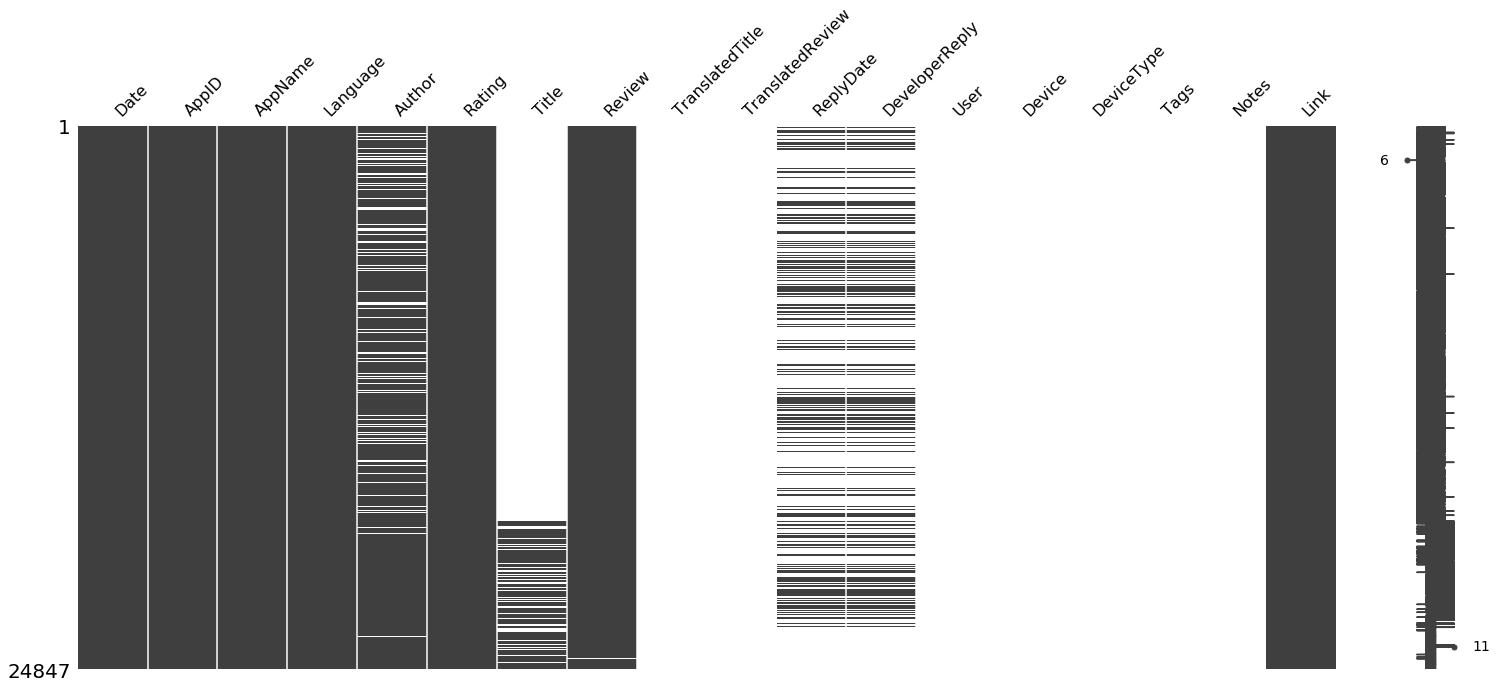

In [3]:
msno.matrix(df)

## Initial Data Cleaning

To simplify the data, features that are less meaningful to our analysis or are too scarcely populated are removed from the dataset.<br>

>Author, User  – Removed unique identifiers. <br>
>AppName – AppID is in a cleaner format and more consistent. AppName contains special characters which did not translate when the data was scraped. <br>
>Language – The reviews should all be in English so this field is not meaningful <br>
>TranslatedTitle, TranslatedReview, User, Device, DeviceType, ReplyDate, DeveloperReply, Tags, Notes – too scarcely populated to provide any meaningful insight. <br>
>Link – Removed as outside of the scope of this project, maybe a field of interest for further analysis. <br>

The observations in the AppID field are then replaced with more common names (i.e. bank names). Where multiple apps exist for the same company, the region and TSX Stock identifier is used to denote the entity.


In [4]:
df = df.drop(["Author","AppName","Language","TranslatedTitle", "TranslatedReview", "ReplyDate","DeveloperReply","User","Device","DeviceType","Tags","Notes","Link"], axis=1)
df['AppID']=df['AppID'].replace({'com.bmo.mobile': 'BMO', 'com.cibc.android.mobi': 'CIBC', 'com.scotiabank.Marimba': 'BNS Caribbean', 'com.td': 'TD', 'com.rbc.mobile.android': 'RBC', 'com.scotiabank.mobile': 'BNS', 'eu.netinfo.colpatria.system': 'Colpatria', 'com.scotiabank.scotiaitrade': 'iTrade', 'com.scotiabank.Marimba.Panama': 'BNS Panama', 'ca.tangerine.clients.phone': 'Tangerine', 'pe.com.scotiabank.tabletbanking': 'BNS Peru'})
print('Dimensions:',df.shape)
df.head()


Dimensions: (24847, 5)


,Date,AppID,Rating,Title,Review
0,2019-01-28,BMO,3,NaN,"Read the other reviews and not sure why other users are having trouble, but I'm given a choice to open the app or the website each time, and have had no issues with either. As for updating, seems comparable to other apps. I make sure to update using wi-fi instead of data to save on charges."
1,2019-01-28,CIBC,1,NaN,great app other than check your credit score not updating itself
2,2019-01-28,CIBC,5,NaN,"super convenient, & easy to navigate through."
3,2019-01-28,BNS Caribbean,3,NaN,Satisfactory but I'm waiting for the day that I can login with my fingerprint.
4,2019-01-28,TD,5,NaN,fast and easy


I initially tried to combine the title and review fields together to create a more complete corpus, but noticed that there was a great deal of duplication in title and review. This skewed the results of my models and was problematic for the N-gram analysis. Instead, I used the title feature to populate missing values in the review field. If the review field had content, the title field was ignored. After a consolidated review feature was created, the original title and review columns are dropped. The last step was to remove the null values which only eliminated 2 observations. The resulting dataframe contained 24,845 observations and 4 features.

In [5]:
df["Reviews"]=df["Review"].fillna(df.Title) #replace NAN values in review with title
df = df.drop(["Title","Review"], axis=1) #drop title and review
df = df[pd.notnull(df['Reviews'])]#remove nulls in new reviews column
print('Dimensions:',df.shape) #show dimensions of data
df.head() #preview


Dimensions: (24845, 4)


,Date,AppID,Rating,Reviews
0,2019-01-28,BMO,3,"Read the other reviews and not sure why other users are having trouble, but I'm given a choice to open the app or the website each time, and have had no issues with either. As for updating, seems comparable to other apps. I make sure to update using wi-fi instead of data to save on charges."
1,2019-01-28,CIBC,1,great app other than check your credit score not updating itself
2,2019-01-28,CIBC,5,"super convenient, & easy to navigate through."
3,2019-01-28,BNS Caribbean,3,Satisfactory but I'm waiting for the day that I can login with my fingerprint.
4,2019-01-28,TD,5,fast and easy


There are a few reviews that are written in French, even though the language setting is set to English only. The below code will detect the language and translate the content to English.

Note: This code takes a long time to run.

In [6]:
from translate import Translator
translator= Translator(to_lang="English")
translation = translator.translate(df['Reviews'])
df['Reviews'] = df['Reviews'].apply(lambda x: translator.translate(x))
df['Reviews']

## DATA VISUALIZATION

### Plot: Number of Review by App ID
Although the number of reviews are disproportionate, the grouping as identified in the overall number of reviews for the "Big 5" Canadian banks were expected. TD and RBC have the most reviews with CIBC disproportionately low in the Big 5 grouping. Surprisingly, the Tangerine app has very few reviews despite being predominately an online banking service. While the number of reviews may be related to the number of app downloads, they are not a direct indicator of app usage or downloads.

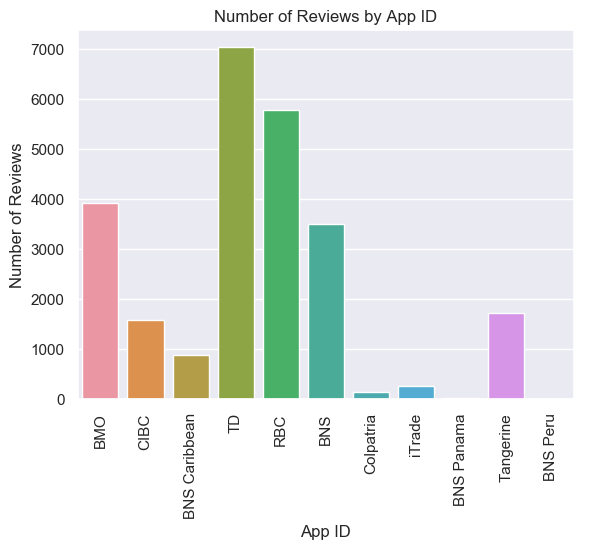

In [7]:
sns.set(style="darkgrid")
bx = sns.countplot(x = "AppID", data=df)
bx.set(xlabel='App ID', ylabel='Number of Reviews',title='Number of Reviews by App ID')
plt.xticks(rotation=90)
plt.show()

### Violin Plot: Ratings by App ID

We can see that the TD app, and to a lesser degree the CIBC app, are very strong performer based on the proportion of app reviews clustering around the upper 5 point rating. Conversely, the iTrade, BNS Peru, and BNS Panama apps are heavily clustered around the lower rating. Another interesting observation is that there is a polarity in the reviews, where the ratings seemed to be clustered at the upper or lower spectrum of the rating scale. This may indicate that reviewers tend to feel strongly when they rate apps opting for either the excellent (5 star) or poor (1 star) ratings. 

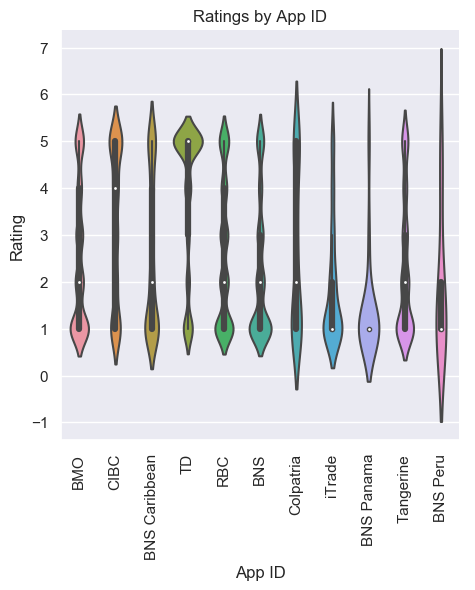

In [8]:
sns.set(style="darkgrid")
cx = sns.catplot(x="AppID", y="Rating",
            kind="violin", data=df);
cx.set(xlabel='App ID', ylabel='Rating',title='Ratings by App ID')
plt.xticks(rotation=90)
plt.show()

### Stacked Plot: (%) Proportion of Ratings by AppID
Viewing the data as a stacked bar plot by (%) proportion of ratings let us see the observed trends more clearly. TD and CIBC, the two previously identified top performers, both have more than 50% of ratings in the positive range (>3-rating). The differentiating factor being that TD has more than 50% of reviews at the top tier 5-rating. The three lowest rating apps BNS Panama, BNS Peru, iTrade have more than 50% of review in the lowest tier (1 star rating), and more than 70% of ratings are lower than 3 stars. An unexpected observation is that all the apps, with the exception of TD and CIBC have more than 50% of the ratings in the negative range (<3-rating).  
 

In [9]:
#create unique list of names
Ratings = df.Rating.unique()
#Compose dictionary dataframe
PullRating = {elem : pd.DataFrame for elem in Ratings}
#create loop and define function
for key in PullRating.keys():
    PullRating[key] = (df[:][df.Rating == key].groupby('AppID').count())       
def give_rating(x):
    return list(PullRating[x].Rating)

In [10]:
#create count lists
r1 = give_rating(1)
r2 = give_rating(2)
r3 = give_rating(3)
r3.insert(4, 0)#need to insert zero for missing Peru
r4 = give_rating(4)
r4.insert(3, 0)#need to insert zero for missing Panama
r5 = give_rating(5)


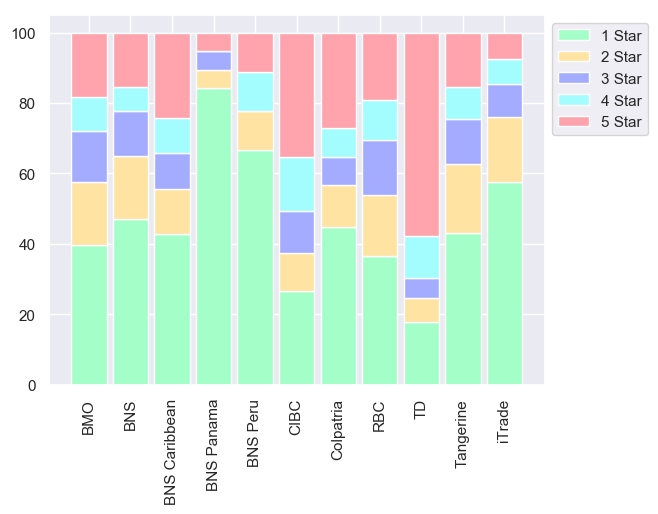

In [11]:
# Data
r = [0,1,2,3,4,5,6,7,8,9,10]
combine = {'s1Bars': r1, 's2Bars': r2,'s3Bars': r3,'s4Bars': r4,'s5Bars': r5}
stack = pd.DataFrame(combine)
 
# Calculate percentage
totals = [i+j+k+l+m for i,j,k,l,m in zip(stack['s1Bars'], stack['s2Bars'], stack['s3Bars'], stack['s4Bars'], stack['s5Bars'])]
s1Bars = [i / j * 100 for i,j in zip(stack['s1Bars'], totals)]
s2Bars = [i / j * 100 for i,j in zip(stack['s2Bars'], totals)]
s3Bars = [i / j * 100 for i,j in zip(stack['s3Bars'], totals)]
s4Bars = [i / j * 100 for i,j in zip(stack['s4Bars'], totals)]
s5Bars = [i / j * 100 for i,j in zip(stack['s5Bars'], totals)]
 
# plot
barWidth = 0.85
names = ( 'BMO' ,'BNS' ,'BNS Caribbean' ,'BNS Panama' ,'BNS Peru' ,'CIBC' ,'Colpatria' ,'RBC' ,'TD' ,'Tangerine' ,'iTrade')
# Create s1 Bars
plt.bar(r, s1Bars, color='#a3ffc7', edgecolor='white', width=barWidth, label="1 Star")
# Create s2 Bars
plt.bar(r, s2Bars, bottom=s1Bars, color='#ffe3a3', edgecolor='white', width=barWidth, label="2 Star")
# Create s3 Bars
plt.bar(r, s3Bars, bottom=[i+j for i,j in zip(s1Bars, s2Bars)], color='#a3acff', edgecolor='white', width=barWidth, label="3 Star")
# Create s4 Bars
plt.bar(r, s4Bars, bottom=[i+j+k for i,j,k in zip(s1Bars, s2Bars, s3Bars)], color='#a3fdff', edgecolor='white', width=barWidth, label="4 Star")
# Create s5 Bars
plt.bar(r, s5Bars, bottom=[i+j+k+l for i,j,k,l in zip(s1Bars, s2Bars, s3Bars, s4Bars)], color='#ffa3ac', edgecolor='white', width=barWidth, label="5 Star")

#X-axis and legend
plt.xticks(r, names, rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
plt.show()



### Table: Measure of Central Tendency (Median; Mean)
The table below shows the mean and median ratings for each app as a measure of central tendency. The median validates the observations from the stacked plot, with TD and CIBC having a median rating of 5 and 4 respectively, and BNS Peru, BNS Panama and iTrade possessing median ratings of 1. Additionally, we can see that all the other apps have median ratings in the negative sentiment range (<3-rating). The measure of mean on ordinal data like ratings is controversial, but I believe the float value provides context to the median rating. Looking at the TD app, 5 stars would seem to indicate a near perfect app, but the mean rating of 3.85 shows us that there are significant negative ratings drawing down this score.



In [12]:
#create summary table for Mean and Median by AppID
table = df[['AppID','Rating']]
table = table.rename(columns={'Rating': 'median'})
table['mean']=df['Rating']
table = table.groupby('AppID').agg({'median':'median', 'mean':'mean'})
table = table.sort_values(['median','mean'],ascending=False)
print(table)

               median      mean
AppID                          
TD             5       3.849169
CIBC           4       3.219187
Colpatria      2       2.610294
BNS Caribbean  2       2.600229
RBC            2       2.591985
BMO            2       2.489019
Tangerine      2       2.343423
BNS            2       2.252854
BNS Peru       1       1.888889
iTrade         1       1.887218
BNS Panama     1       1.368421


### Plot: Distribution of Reviews by Rating

Finally, this plot views the distributions of reviews across all ratings. We can see that the number of positive and negative reviews are relatively similar, which may indicate that we can have a relatively high degree of confidence in the sentiment identified from this dataset.


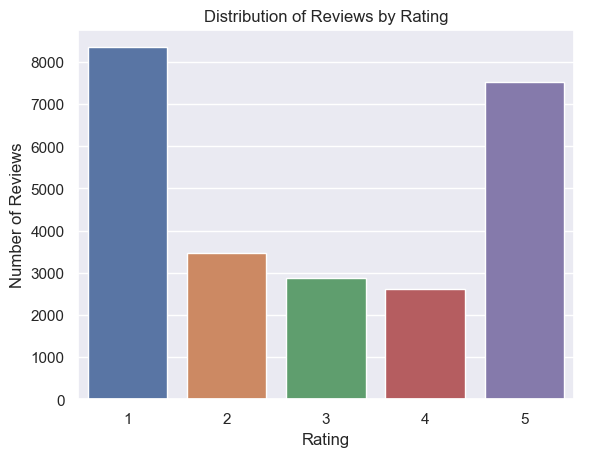

In [13]:
sns.set(style="darkgrid")
bx = sns.countplot(x = "Rating", data=df)
bx.set(xlabel='Rating', ylabel='Number of Reviews',title='Distribution of Reviews by Rating')
plt.show()

## DATA PREPARATION AND CLEANING

My initial attempts at lemmatizing the review text were unsuccessful as a spot check of the corpus showed many words that were not transformed to their base form. Upon further research, it was noted that the default setting for the lemmatization module in NTLK wordnet was ‘noun’ resulting in the transformation of only noun words. To resolve this, the function below defines the word type based on the position tag obtained from the NLTK pos_tag module (the pos_tag module is applied in the clean_text function in the following section).


In [14]:
def get_tag(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

The clean_text function defined below applies the following transformations: <br>
> 1) Change all words to lower case (lemmatization does not work on capitals as they are assumed to be proper nouns). <br>
> 2) Tokenize the text and remove punctuation. <br>
> 3) Remove numeric values. <br>
> 4) Remove stop words (using pre-built stop word dictionary). <br>
> 5) Remove any empty tokens. <br> 
> 6) Apply a position tag to each word and define it based on the previously defined get_tag function as adjective, noun, verb, or adverb.<br>
> 7) Lemmatize the words. <br>
> 8) Remove any single letter words resulting from lemmatization.<br>

In [15]:
def clean_text(text):
    text = text.lower() #change all text to lower case
    text = [word.strip(string.punctuation) for word in text.split(" ")] #tokenize and remove punctuation
    text = [word for word in text if not any(c.isdigit() for c in word)] #remove numeric values
    stop = stopwords.words('english') #call english stop word dictionary
    text = [x for x in text if x not in stop]#remove stop words
    text = [t for t in text if len(t) > 0] #remove empty tokens
    pos_tags = pos_tag(text)#apply position tag to text
    text = [WordNetLemmatizer().lemmatize(t[0], get_tag(t[1])) for t in pos_tags] #apply pos_tag function and lemmatize text
    text = [t for t in text if len(t) > 1]# remove single letter words
    text = " ".join(text) #combine
    return(text)
#create new column with cleaned text
df["reviews_clean"] = df["Reviews"].apply(lambda x: clean_text(x))

Previewing the results for pre-cleaning and post-cleaning.

In [16]:
print('Before Text Cleaning')
df['Reviews'].head()

Before Text Cleaning


0    Read the other reviews and not sure why other users are having trouble, but I'm given a choice to open the app or the website each time, and have had no issues with either. As for updating, seems comparable to other apps. I make sure to update using wi-fi instead of data to save on charges.
1    great app other than check your credit score not updating itself                                                                                                                                                                                                                                   
2    super convenient, & easy to navigate through.                                                                                                                                                                                                                                                      
3    Satisfactory but I'm waiting for the day that I can login with my fingerprint.                          

In [17]:
print('After Text Cleaning')
df['reviews_clean'].head()

After Text Cleaning


0    read review sure user trouble i'm give choice open app website time issue either update seem comparable apps make sure update use wi-fi instead data save charge
1    great app check credit score update                                                                                                                             
2    super convenient easy navigate                                                                                                                                  
3    satisfactory i'm wait day login fingerprint                                                                                                                     
4    fast easy                                                                                                                                                       
Name: reviews_clean, dtype: object

Drop all columns that are blank as a results of the text cleaning function. Lost 35 rows.

In [18]:
print(df.shape)
df = df[df['reviews_clean'].map(len) > 0]
print(df.shape)

(24845, 5)
(24810, 5)


## FEATURE ENGINEERING

### Sentiment Analysis

The Vader module from NLTK was the model selected for sentiment analysis. The Vader module uses a prebuilt lexicon of words to calculate a sentiment score. This module was selected for sentiment analysis because the module takes into consideration the context of the text. The module returns 4 values: positivity score, neutrality score, negativity score and summary score.


In [19]:
sid = SentimentIntensityAnalyzer()
#calculates the negativity,  neutrality, positivity and overall sentiment scores
df["sentiments"] = df["reviews_clean"].apply(lambda x: sid.polarity_scores(x))
#drop sentiment column and add the 4 sentiment scores as separate features to primary dataset
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
df[['AppID','Rating','reviews_clean','neg','neu','pos','compound']].head(10)

C:\Users\s2555246\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,AppID,Rating,reviews_clean,neg,neu,pos,compound
0,BMO,3,read review sure user trouble i'm give choice open app website time issue either update seem comparable apps make sure update use wi-fi instead data save charge,0.081,0.687,0.233,0.6249
1,CIBC,1,great app check credit score update,0.000,0.374,0.626,0.7717
2,CIBC,5,super convenient easy navigate,0.000,0.227,0.773,0.7783
3,BNS Caribbean,3,satisfactory i'm wait day login fingerprint,0.000,0.667,0.333,0.3612
4,TD,5,fast easy,0.000,0.256,0.744,0.4404
5,TD,4,try twice ap recognize amount correctly,0.000,1.000,0.000,0.0000
6,TD,1,"stressful download app android smart phone manage it,i stare app icon say continue,the app need perform mandatory update there install button direct add happy.the developer something use ios,there problem allð",0.167,0.722,0.111,-0.4588
7,CIBC,5,great service,0.000,0.196,0.804,0.6249
8,TD,1,terrible deposit never available td bank bank available google samsung pay think switch bank use dated feature,0.231,0.769,0.000,-0.5423
9,TD,5,easy convenient use,0.000,0.408,0.592,0.4404


The graph below shows the compound sentiment calculated by Vader distributed by good and bad reviews. We can see that good reviews are mostly considered very positive by Vader, whereas, bad reviews are more dispersed with a slightly higher proportion of negative reviews with negative sentiment scores. The only variation to this trend is the slight peak around the neutral compound score (zero) for both negative and positive reviews.

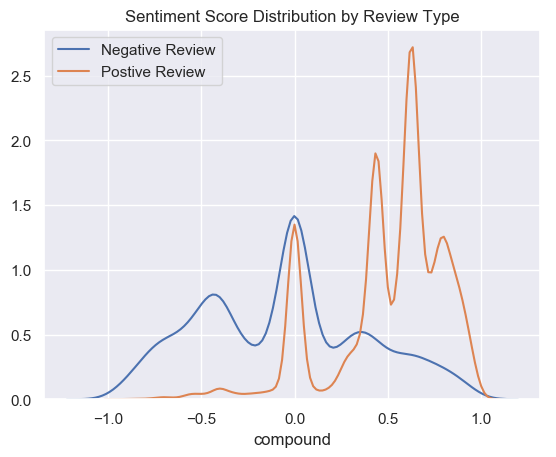

In [20]:
for x in [1, 5]:
    subset = df[df['Rating'] == x]
    if x > 3:
        label = "Postive Review"
    else:
        label = "Negative Review"    
    sns.distplot(subset['compound'], hist = False, label = label).set_title('Sentiment Score Distribution by Review Type')


My initial intention was to use the 4 sentiment scores to divide the 3-star review into good and bad reviews but the Vader module has some issues with interpreting sarcasm. For example, one of the reviews from my spot check was "Great, now the app won't take my finger print". Vader assigned this review a relatively high positive score accounting for the word "great" in the review when the sentiment of the text in context is clearly negative or sarcastic.



### Word and Character Count Features

Two new features are created by extracting the number of characters and number of words per review. Log transformation is applied to pull in outliers.


In [66]:
df["num_chars"] = df["reviews_clean"].apply(lambda x: len(x))
df["num_words"] = df["reviews_clean"].apply(lambda x: len(x.split(" ")))
#log transformation
df['num_chars1'] = np.log(df['num_chars'])
df['num_words1'] = np.log(df['num_words'])

We can see a trend forming from the boxplot below, where users tend to leave longer reviews for negative ratings (<3) and neutral ratings (=3) and shorter reviews good review (>3). This may be a useful feature for our predictive models.


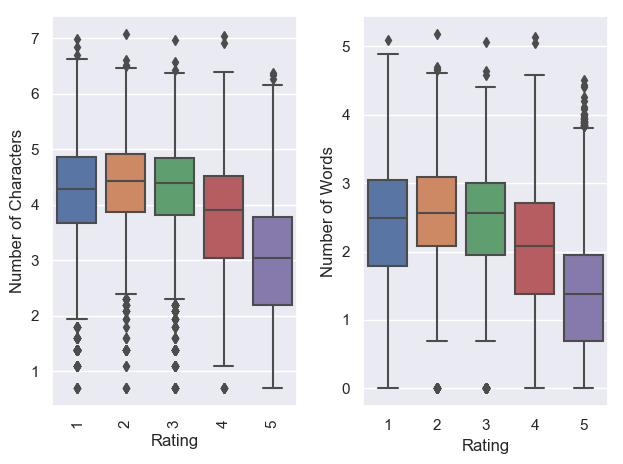

In [23]:
x1 = df['Rating']
x2 = df['Rating']
y1 = df['num_chars1']
y2 = df['num_words1']
#plot num_chars by rating in column 1
plt.subplot(1, 2, 1)
plt.xticks(rotation=90)
g = sns.boxplot(x1, y1)
g.set(xlabel='Rating', ylabel='Number of Characters',title='')
#plot num_words by rating in column 2
plt.subplot(1, 2, 2)
g = sns.boxplot(x2, y2)
g.set(xlabel='Rating', ylabel='Number of Words',title='')

plt.tight_layout()
plt.show()

### Doc2Vec Feature Creation

The doc2vec method from the Genism module is used to generate document vectors for each cleaned review. The doc2vec module uses a modified word2vec model with the addition of a document unique vector, which numerically represents the document. This provides a document-concept representation of each review. This feature is important for training our model since similar texts should have similar vector representations. We first start by creating doc2vec vector columns and then proceed to train the model. The model is then applied to the text to transform each review into vector data before being combined with our original dataframe.

Warning Message to install compiler to speed up genism is not necessary for the size of data used in this notebook. For larger data, a compiler would be recommended as this model took roughly 26 minutes to run.


In [25]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["reviews_clean"].apply(lambda x: x.split(" ")))]
# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=6, window=2, min_count=1, workers=4)
# transform each document into a vector data
df_vector = df["reviews_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
df_vector.columns = ["df_vector_" + str(x) for x in df_vector.columns]
df = pd.concat([df, df_vector], axis=1)

C:\Users\s2555246\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


### Term Frequency - Inverse Document Frequency

The word frequency is calculated using the TF-IDF model. In addition to just counting word frequency, this model computes the relative importance of each word based on the frequency of occurrence of the word in each text. A column is generated for every word which occurs in a minimum of 10 different documents to provide a relative filter on importance and to remove size. This can be adjusted to fine tune the predictive models.


In [26]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["reviews_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

### Define Good and Bad Reviews

The final feature created is to define a bad review ( rating < 3) by denoting it with 1 and all other ratings with 0. For the purposes of our model, the neutral reviews (rating of 3) are separated into another dataframe. Our dataset is relatively balanced with 53.9% bad review and 46.1% good reviews.

In [65]:
df.shape

(24810, 1905)

In [27]:
df['is_bad'] = np.where(df['Rating']<3, 1, 0)
#take lowest and highest rating
df_class = df[(df['Rating'] < 3) | (df['Rating'] > 3)]
df_neutral = df[(df['Rating'] == 3)].drop(['is_bad'], axis=1)
df_class = df_class.sort_values(by=['Rating'])
print ("Dimenions:", df_class.shape)
print ("Good (0) vs Bad (1) split:" "\n",df_class["is_bad"].value_counts(normalize = True))
df_class.groupby('is_bad').count()

Dimenions: (21929, 1905)
Good (0) vs Bad (1) split:
 1    0.53883
0    0.46117
Name: is_bad, dtype: float64


,Date,AppID,Rating,Reviews,reviews_clean,neg,neu,pos,compound,num_chars,...,word_year,word_yes,word_yesterday,word_yet,word_yo,word_you,word_your,word_yr,word_zero,word_zoom
is_bad,,,,,,,,,,,,,,,,,,,,,
0,10113,10113,10113,10113,10113,10113,10113,10113,10113,10113,...,10113,10113,10113,10113,10113,10113,10113,10113,10113,10113
1,11816,11816,11816,11816,11816,11816,11816,11816,11816,11816,...,11816,11816,11816,11816,11816,11816,11816,11816,11816,11816


## MODEL DEVELOPMENT

The Random Forest model (RF) is used to predict if a review is good or bad given the various features we created from the review text. The model will then be used on the neutral dataset (rating = 3) to categorize the reviews.

### Random Forest Classifier

The features used to train the RF model are selected and any columns to be ignored are defined. The dataset is then split into training and test datasets.

In [46]:
# feature selection
label = "is_bad"
ignore_cols = [label, "Reviews", "reviews_clean", "Date", "AppID","Rating","is_bad"]
features = [c for c in df_class.columns if c not in ignore_cols]
# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_class[features], df_class[label], test_size = 0.25, random_state = 42)

The resultant dataset for training is 17,543 rows x 1,899 columns and the test dataset is 4,386 rows x 1,899 columns. The 80/20 split was used as the app dataset is relatively small.

In [47]:
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Testing Features Shape:', X_test.shape)
print('Testing Labels Shape:', y_test.shape)

Training Features Shape: (16446, 1899)
Training Labels Shape: (16446,)
Testing Features Shape: (5483, 1899)
Testing Labels Shape: (5483,)


The RF model is trained and cross validation is run to get a better overview of our model's performance.

In [49]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 120, random_state = 42)
rf.fit(X_train, y_train)
#Cross Validation Score
rfc_cv_score = cross_val_score(rf, df_class[features], df_class[label], cv=10, scoring= 'roc_auc')

Train Accuracy ::  0.9998783898820381
Test Accuracy  ::  0.8723326645996717


### Model Evaluation

#### Confusion Matrix:
The RFC model predicted 205 reviews as good incorrectly and 495 review as bad incorrectly.

#### Classification Report:
The model achieved an average precision of 0.88, average recall of 0.87 and average accuracy of 0.87. We can see the model has higher precision when it comes to predicting positive review. This may be because the positive sentiment is the most important feature for our model (refer to Feature Importance section).

#### Cross Validated (CV) AUC Score:
The model achieved an average CV AUC score of 0.94 which indicates a relatively good model.


In [64]:
print('CONFUSION MATRIX')
#print(confusion_matrix(y_test, rf.predict(X_test)))
print (pd.crosstab(y_test, rf.predict(X_test), rownames=['Actual Result'], colnames=['Predicted Result']))
print('\n')
print('CLASSIFICATION REPORT')
print(classification_report(y_test, rf.predict(X_test)))
print('\n')
print('ALL AUC SCORES')
print(rfc_cv_score)
print('\n')
print('MEAN AUC SCORE: ', rfc_cv_score.mean())

CONFUSION MATRIX
Predicted Result     0     1
Actual Result               
0                 2036  495 
1                 205   2747


CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      2531
           1       0.85      0.93      0.89      2952

   micro avg       0.87      0.87      0.87      5483
   macro avg       0.88      0.87      0.87      5483
weighted avg       0.88      0.87      0.87      5483



ALL AUC SCORES
[0.84618295 0.88664578 0.90392782 0.94750009 0.96901595 0.9711331
 0.97248053 0.95694231 0.96222082 0.96465551]


MEAN AUC SCORE:  0.9380704862597613


### Receiver Operating Characteristics (ROC) Curve
The trade-off between the true positive (TP) and false positive (FP) rate is shown in the Receiver Operating Characteristics (ROC) curve, and can be used to access the quality of the classifier used in our model. The distance between the ROC curve and the diagonal baseline indicates the reliability of the predictions from our model. The model is quite good with an area under curve (AUC) value of 0.94.


Note: ROC is not a good indicator of model quality if the data is skewed towards a specific outcome as this could mute the FP and FN prediction rates (depending on the skewing of data). The app data review was relatively balanced in terms of the number of defined good or bad reviews, which give us some confidence in the ROC curve.


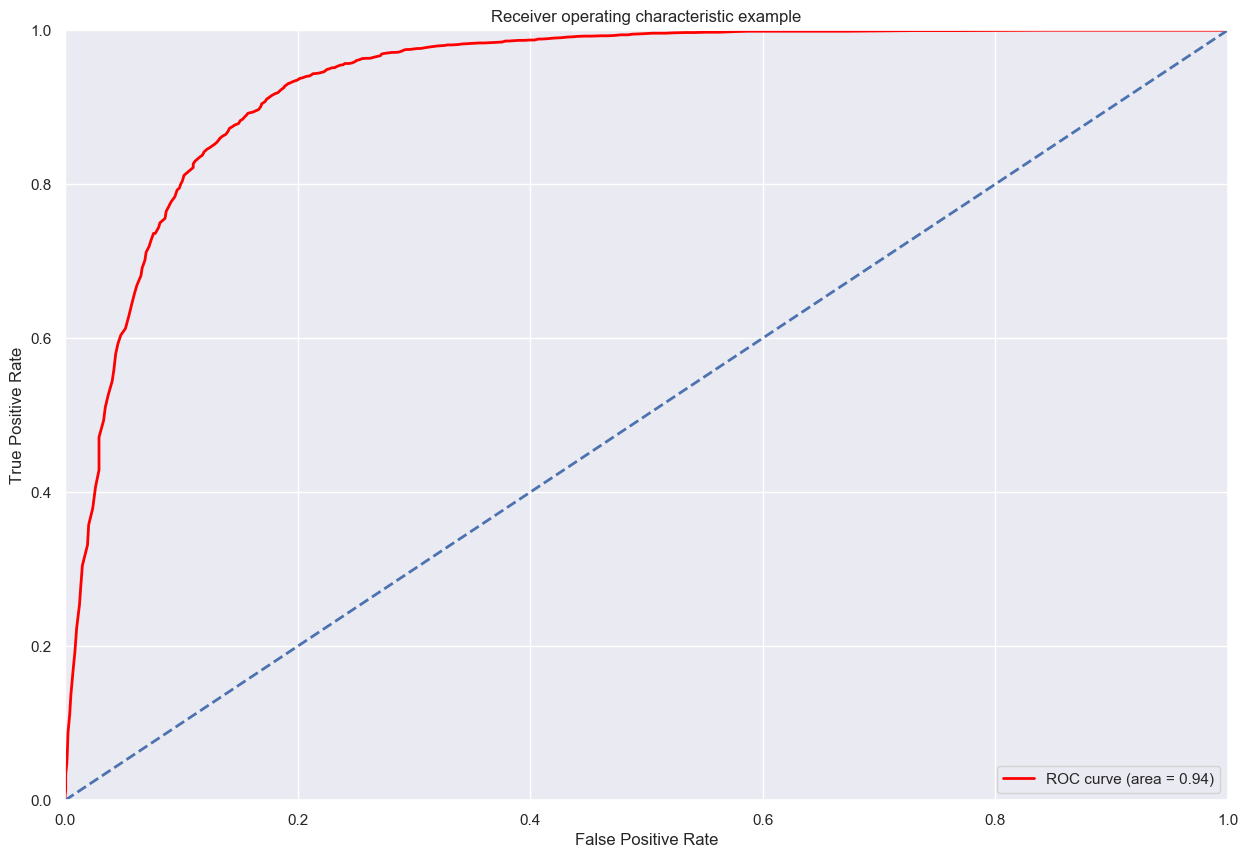

In [31]:
y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)
roc_auc = auc(fpr, tpr)
plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='red',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Precision Recall Curve (Average Precision)

The PR curve shows the calculated precision and recall at various threshold values. The precision values for our model remain relatively stable at each threshold. <br>
> Precision (positive prediction value) is the ratio of TP/ (TP + FP) <br>
> Recall (sensitivity) is the ratio of TP/(TP + FN) <br>

Note: The PR curve is useful for dataset that are imbalanced. 


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.93')

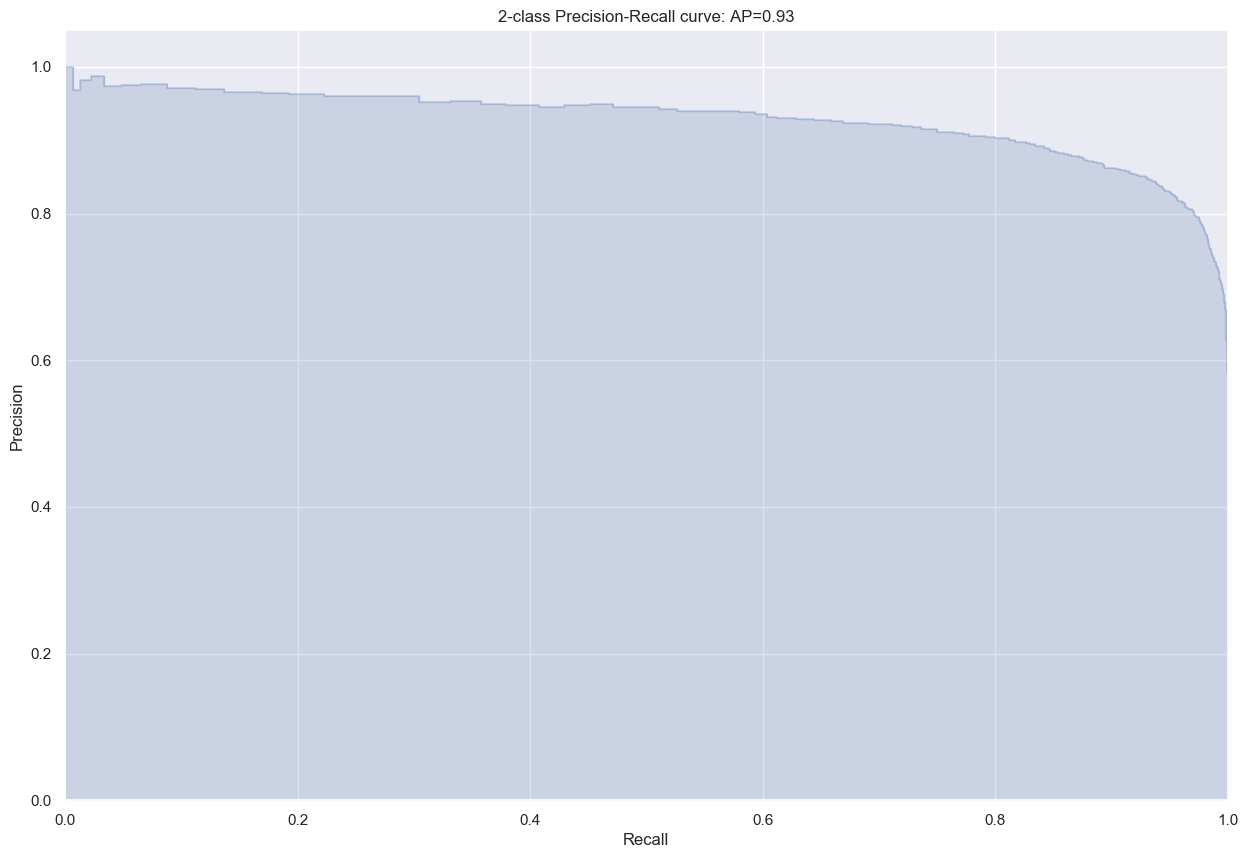

In [32]:
average_precision = average_precision_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

### Feature Importance

The most important features were the 4 sentiment scores generated by Vader, the number of words and characters, the doc2vec features. Additionally, some words identified by TF-IDF such as “great”, "easy" and “love” have fairly high importance. There may be some correlation between the Vader “pos” scores and the TD-IDF words “great”, "easy" and “love”.


In [34]:
# show feature importance
feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
feature_importances_df.head(20)

,feature,importance
2,pos,0.108011
3,compound,0.067237
1,neu,0.054401
0,neg,0.050472
4,num_chars,0.045111
5,num_words,0.031604
8,df_vector_2,0.026204
11,df_vector_5,0.018919
7,df_vector_1,0.018370
702,word_great,0.016891


## Model Application

The RF model is applied to the dataset with ratings of 3 to determine if the reviews are good or bad.

In [35]:
df_temp = df_neutral[['Date','AppID','Rating','Reviews','reviews_clean']]
df_neutral = df_neutral.drop(['Reviews','reviews_clean','Date','AppID','Rating'], axis=1)
df_neutral['prediction'] = rf.predict(df_neutral)
df_neutral = pd.concat([df_temp.reset_index(drop=True),df_neutral.reset_index(drop=True)], axis=1)

## Preview Predicted Reviews

### Predicted Bad Reviews
For the most part, the model seems to have done a pretty good job of categorizing the neutral reviews. Based on the preview we can see a couple of issues being highlighted by reviewers:
> No finger print access/Touch ID <br>
> Lack of features (investment portfolio, use of debit card) <br>
> Errors in transactions ( failed EFT, failed deposit, etc.) <br>

In [36]:
print('Predicted Bad Reviews')
dfn_pred_bad = df_neutral[(df_neutral['prediction'] == 1)]
dfn_pred_bad['Reviews'].head(10)

Predicted Bad Reviews


0     Read the other reviews and not sure why other users are having trouble, but I'm given a choice to open the app or the website each time, and have had no issues with either. As for updating, seems comparable to other apps. I make sure to update using wi-fi instead of data to save on charges.
1     Satisfactory but I'm waiting for the day that I can login with my fingerprint.                                                                                                                                                                                                                     
2     this app was great until Dec.10 update. E-transfers keep saying the couldn't go through because they couldn't find the email I was sending the transfer to. never had any issues before the update and the info has not changed for the e-transfer                                                 
3     why can i use my interac card to pay with my phone only with my visa                                

### Predicted Good Reviews

The predicted good review preview seems to be less insightful, but this is somewhat expected given the high neutrality score noted during the Vader sentiment step. We see the model has failed to identify sarcasm in line 10: “It’s a bit of a joke, My opinion anyway…”, “Great app would be nice to check your credit score like every other banking app…” and “Finger print for password would be great…” 

We noted that our model weighed positive words very heavily in feature importance, which would explain these results. 


In [37]:
print('Predicted Good Reviews')
dfn_pred_good = df_neutral[(df_neutral['prediction'] == 0)]
dfn_pred_good['Reviews'].head(10)

Predicted Good Reviews


5     2019-01-26 (3/5): Please, allow us to receive notifications for all transactions like other credit cards apps do. Then I'll upgrade my review. It allows me to confirm live to a merchant that the transaction is paid. Thank you                        
10    It's a bit of a joke. My opinion anyway...                                                                                                                                                                                                               
12    It was great until something happened.. I don't get any notifications from RBC anymore. Everything is turned on. I even uninstalled the app and no luck.                                                                                                 
19    I just use this for the bare minimum things checking account balances and bill payments and have just started using the cheque deposit feature, which worked great. This has been buggy with some features though, like toggling o

## REVIEW INSIGHTS

Now that we have our cleaned review data and have split the neutral ratings into good or bad categories. We can examine the text to see what insights we can gather.

### Word Cloud

The word cloud is a visual representation of word frequency. We can immediately identify some key app services that seem to be important to customers, such as cheque, transfer, and deposits. This method is somewhat controversial as it is difficult to interpret relative size (and therefore frequency) of words. It is also difficult to interpret context when isolated words are presented, such as in the case of "work, use, update and service" which can be positive or negative.

Additional word clouds can be viewed in the appendix of this notebook.


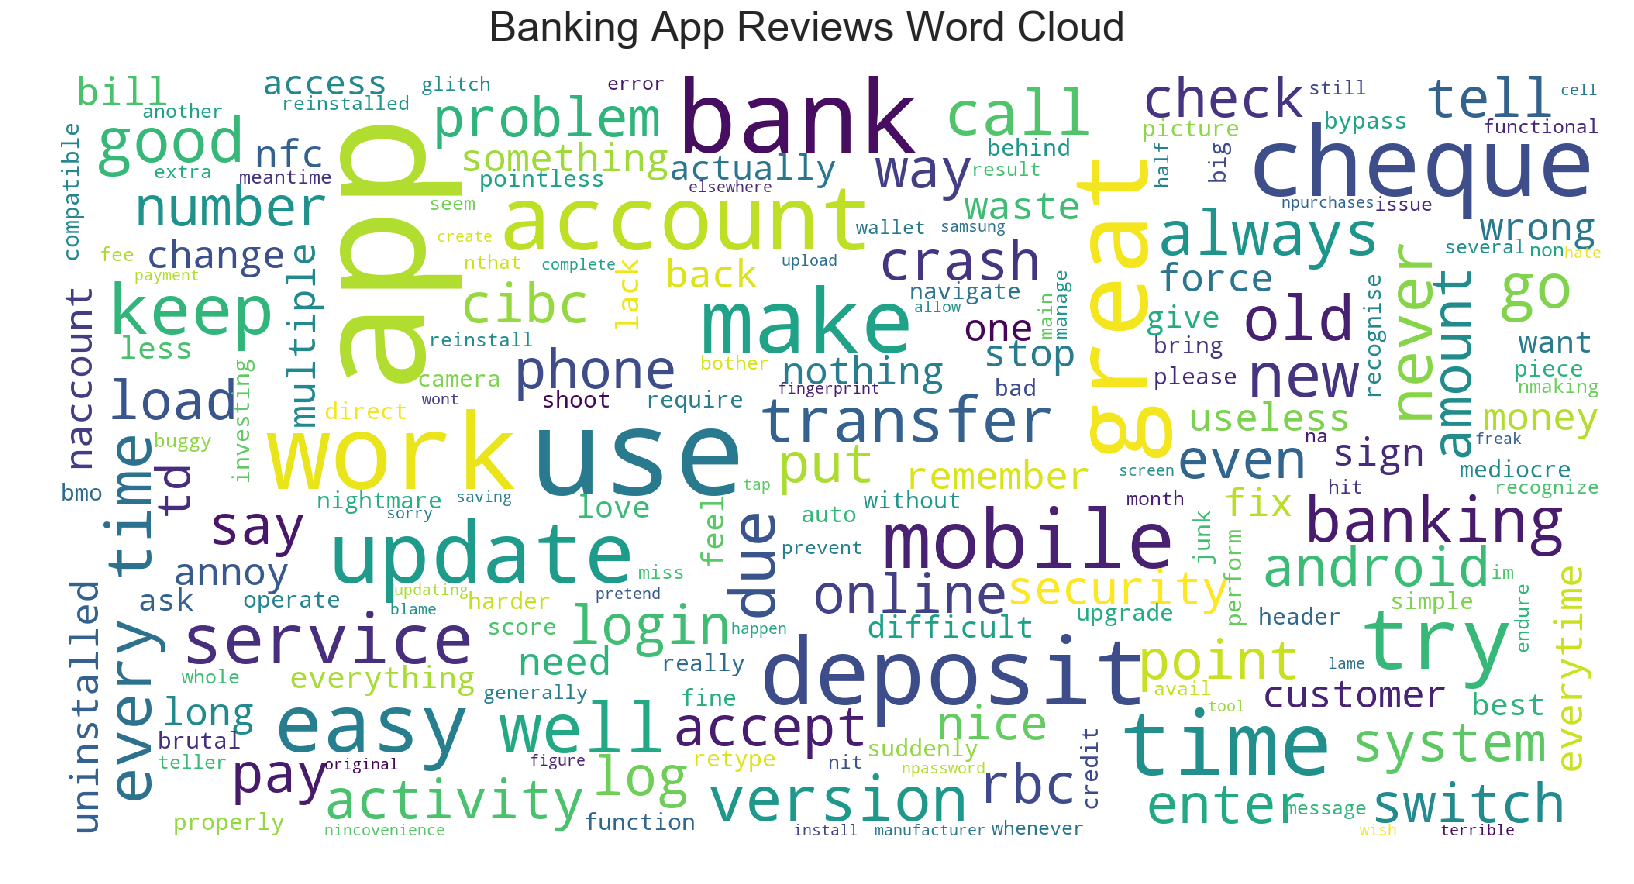

In [38]:
wd_title = 'Banking App Reviews Word Cloud'
def show_wordcloud(data, title = wd_title):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 5,
        random_state = 52
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 30)
        fig.subplots_adjust(top = 1.4)

    plt.imshow(wordcloud)
    plt.show() 
#show word cloud
show_wordcloud(df_class["reviews_clean"])

### N-Gram Analysis

N-grams are all the continuous sequence of words created from all the combinations of adjacent words in a text, with the variable n denoting the desired sequence length. By viewing sequences of text, we can overcome the shortcomings of the word clouds and draw some context from the common phrases seen in the review text.

The n_gram defined below creates a list of n-grams at the desired sequence length.



In [39]:
def n_gram(token, n_gram, size ):
    tokenized = token.apply(lambda x: x.split())
    finder = BigramCollocationFinder.from_documents(tokenized.values)
    bigram_measures = nltk.collocations.BigramAssocMeasures()
    finder.apply_freq_filter(1)
    result = finder.nbest(bigram_measures.pmi, 10)
    ngram_list = [pair for row in tokenized for pair in ngrams(row, n_gram)]
    counts = Counter(ngram_list).most_common()
    print (pd.DataFrame.from_records(counts, columns=['gram', 'count']).head(size))

Taking an initial look at the n-grams for the entire cleaned corpus, we can see mostly negative phrases which make somewhat sense considering that negative reviews tend to have more text. The most prevalent complaints being technical issues, app crashes, cheque deposit functionality, and session time outs. These are possible areas for the app developers to address to improve customer satisfaction.


### Positive N-Grams

Aside from the praise for the app, we can glimpse some features that customers like about the banking apps. App users enjoy  banking apps that offer the same services as in-person banking: cheque deposits, balance transfers, bill payments and viewing credit card transactions. A successful banking app seems to be defined by the ability to make banking easier, convenient and more accessible.


In [40]:
df_best = df_class[(df_class['is_bad'] == 0)]
n_gram(df_best['reviews_clean'], 5, 15)

                                       gram  count
0   (app, make, life, much, easy)            9    
1   (best, banking, app, i've, ever)         5    
2   (banking, app, i've, ever, use)          5    
3   (save, much, time, go, bank)             5    
4   (app, make, banking, much, easy)         5    
5   (balance, transfer, money, pay, bill)    3    
6   (love, app, make, life, much)            3    
7   (deposit, cheque, without, go, bank)     3    
8   (great, app, make, banking, easy)        3    
9   (use, app, time, pay, bill)              3    
10  (best, banking, app, i've, use)          3    
11  (app, keep, get, well, well)             3    
12  (app, make, life, easy, love)            3    
13  (credit, card, transaction, real, time)  3    
14  (great, save, time, go, bank)            3    


### Negative N-Grams
Negative n-grams can be grouped into two types of feedback. The first group is technical errors, mainly app crashes and issues with cheque deposits. The second group is functionalities that inconvenience the customer, namely security questions and not being able to save their card number.

In [41]:
df_worst = df_class[(df_class['is_bad'] == 1)]
n_gram(df_worst['reviews_clean'], 5, 20)

                                           gram  count
0   (session, expire, due, lack, activity)       13   
1   (crash, crash, crash, crash, crash)          11   
2   (security, question, every, single, time)    10   
3   (every, time, try, deposit, cheque)          8    
4   (technical, difficulty, please, try, later)  7    
5   (security, question, every, time, log)       7    
6   (client, card, number, every, time)          7    
7   (answer, security, question, every, time)    7    
8   (every, time, try, take, picture)            7    
9   (crash, every, time, try, take)              6    
10  (ask, security, question, every, time)       6    
11  (try, deposit, cheque, app, crash)           6    
12  (app, crash, every, time, try)               6    
13  (say, something, go, wrong, end)             6    
14  (last, update, can't, deposit, cheque)       5    
15  (enter, client, card, number, every)         5    
16  (never, remembers, client, card, number)     5    
17  (card,

### Predicted Positive N-gram

Trigrams were used for the predicted positive results, as bigrams were not very insightful and longer n-grams returned very low counts. One interesting observation is the common occurrence of phrases like "would like...", "would be great", etc. This seems to highlight some useful feedback for improving the apps and warrants a closer look.


In [42]:
n_gram(dfn_pred_good['reviews_clean'], 3, 15)

                         gram  count
0   (would, like, see)         6    
1   (app, work, great)         5    
2   (app, would, nice)         4    
3   (finger, print, scanner)   4    
4   (would, love, able)        4    
5   (check, credit, score)     3    
6   (like, see, fingerprint)   3    
7   (mobile, cheque, deposit)  3    
8   (would, nice, able)        3    
9   (support, google, pay)     3    
10  (app, work, well)          3    
11  (good, app, would)         3    
12  (quickly, check, balance)  3    
13  (app, user, friendly)      3    
14  (would, like, able)        3    


Just previewing the predicted positive review containing the word "would" has highlighted several useful suggestions from app users. Some suggestions from app users include:
- finger print security. <br>
- view investments, credit score, transactions and bill history. <br>
- improvement to app appearance and interface.


In [43]:
dfn_pg= dfn_pred_good[dfn_pred_good['reviews_clean'].str.contains("would")]
#dfn_pg['Reviews'].head(10)
dfn_pg['reviews_clean'].head(10)

43     great app would nice check credit score like every bank app thow                                                                                                                                                                                                                    
46     finger print password would great                                                                                                                                                                                                                                                   
100    good wished would fingerprint reader like second security                                                                                                                                                                                                                           
191    would like see investment like rbc direct account account summary otherwise like app much thank                                              

### Predicted Negative N-grams

The predicted negative n-grams had similar results to the negative n-grams. The common issues highlighted by users were app crashes and errors. Many of the users wanted more streamlined log-in and validation options, and would like to see finger print access, Google pay functionality and direct investing functions added to the apps.


In [44]:
n_gram(dfn_pred_bad['reviews_clean'], 4, 15)

                                gram  count
0   (something, go, wrong, end)       7    
1   (i've, log, due, inactivity)      7    
2   (card, number, every, time)       7    
3   (say, something, go, wrong)       6    
4   (please, add, finger, print)      5    
5   (say, sign, due, inactivity)      5    
6   (take, picture, cheque, deposit)  5    
7   (crash, every, time, try)         5    
8   (every, time, try, deposit)       5    
9   (card, number, every, single)     5    
10  (number, every, single, time)     5    
11  (every, time, try, log)           4    
12  (would, also, like, see)          4    
13  (type, password, every, time)     4    
14  (samsung, pay, google, pay)       4    


## SUMMARY 

The Android app review dataset initially had 24,825 rows and 4 columns following the initial round of data cleaning. Sentiment scores (positive, negative, neutral and compound), document vectors, word counts, character counts, and term frequency features were created, resulting in 1,900 new features. The reviews deemed neutral (rating = 3) was separated, and only definitive reviews with ratings greater than or less than 3 were used in the model. 

The random forest classification model had an accuracy of 87%, precision of 88%, recall of 87% and average cross validated ROC AUC of 94% indicating a relatively good model. The most important features were the 4 sentiment scores (positive, compound, neutral and negative), word and character counts, a few document vectors, and the words great and easy (from TD-IDF). The model was then applied to the neutral reviews to try and categorize the review into positive or negative. 

A possible area of improvement for the model was the sentiment scores. The Vader module scored positive words very high which impacted predictions, as sarcastic or unconstructive reviews were classified as positive. 


## RESULTS

Customers like a banking app that can offer the same services as in-person banking and online banking. Some key functions that users enjoyed were mobile cheque deposits, account balance transfers, bill payment and the capability to view credit card transactions. 

Customer disliked banking apps prone to technical issues such as crashing or failed transactions, specifically involving mobile cheque deposits. Many complaints mentioned security and validation requirements that made accessing the app inconvenient, mainly having to always input security questions or not being able to save account login information.

The neutral review provided suggestions like adding finger print security, the ability to view investments, credit score, transaction histories, direct investing capabilities, Google pay integration, and to improve the apps appearance and interface.


## AREAS FOR FUTURE DEVELOPMENT


- Examine word vector vizualizations to see what insights can be learned (word2vec).
- Include n-grams in training set for models and evaluate if accuracy is improved.
- Train model to determine sentiment specific to review text (perhapse SVM model with sparse matrix). Determine if accuracy improve in model and predictions.
- Create custom stop word list to improve model accuracy.

***

## APPENDIX

The appendix contains any additional plots, code or analysis not explicitly used in project analysis.

### More Word Clouds


Positive Review Preview
6703     app amaze easy use definitely star worthy \nlove                                     
13214    awesome convenient satisfy td canada trust thank help                                
2963     love monitor credit rating well app great thank                                      
6378     super fast super secure super easy convenient today's busy \nlifestyle love thanks td
8796     love super easy save trip bank love thank td app keep good work                      
381      excellent banking app clean interface user friendly efficient time save love         
14562    good service cibc good staff good customer support love                              
7604     easy use user friendly love mobile deposit great                                     
2573     deposit cheque td app amazing great easy fun                                         
11297    love app user friendly easy use perfect need                                         
Name: reviews_clean, dtype

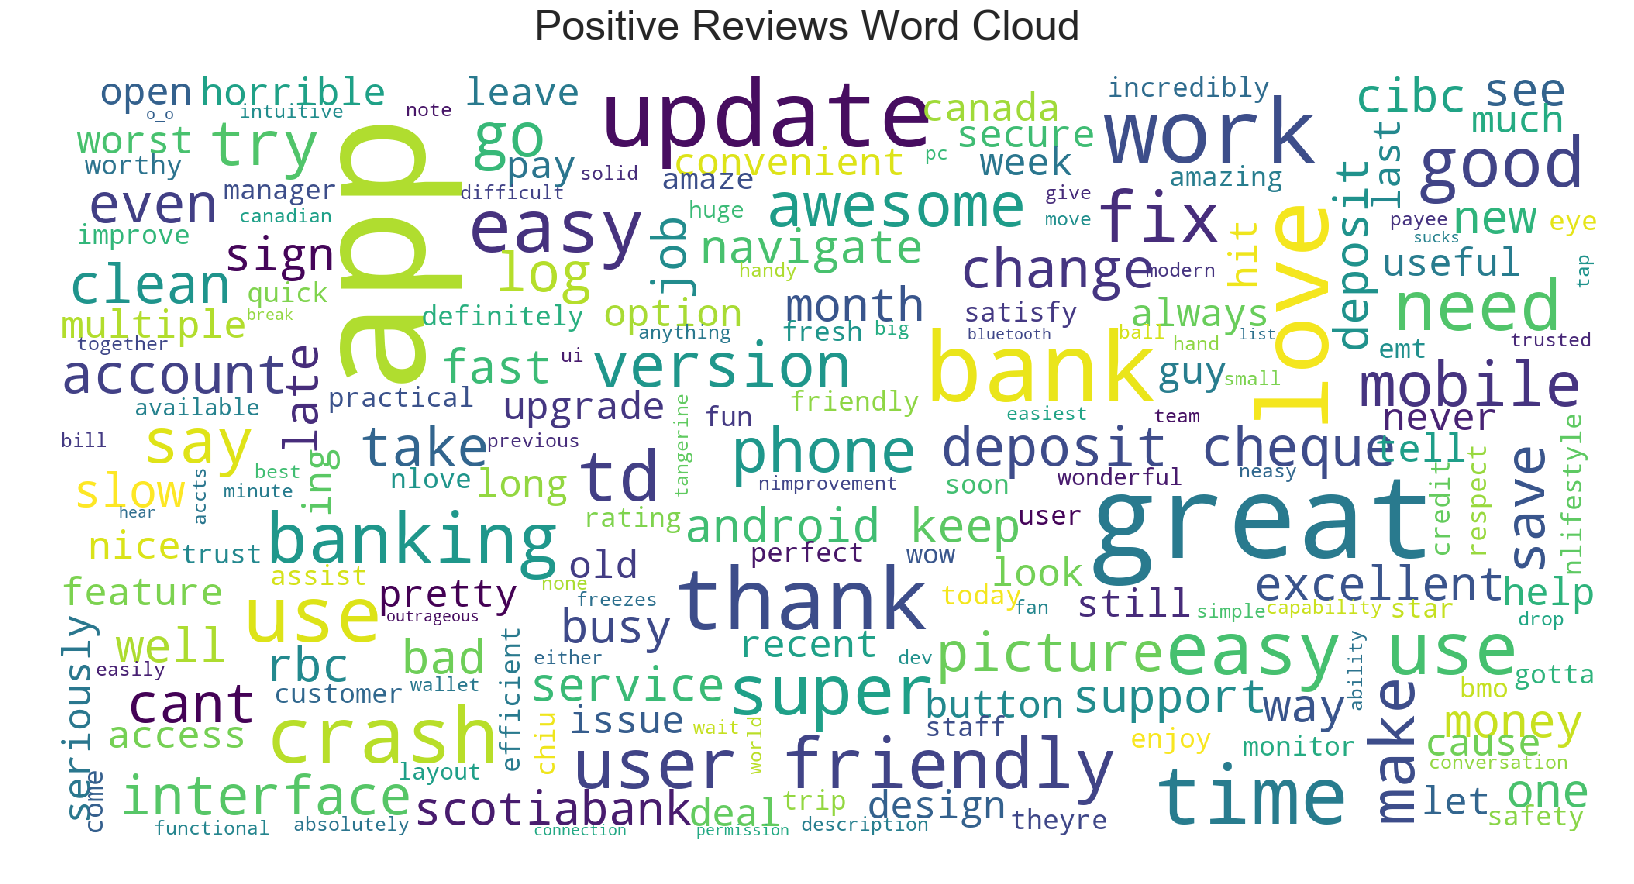

In [55]:
df_highest = df_class[df_class["num_words"] >=8].sort_values("pos", ascending = False)[["reviews_clean", "pos"]]
print("Positive Review Preview")
print(df_highest['reviews_clean'].head(10))
# print wordcloud
wd_title = 'Positive Reviews Word Cloud'
show_wordcloud(df_highest["reviews_clean"], title = wd_title)

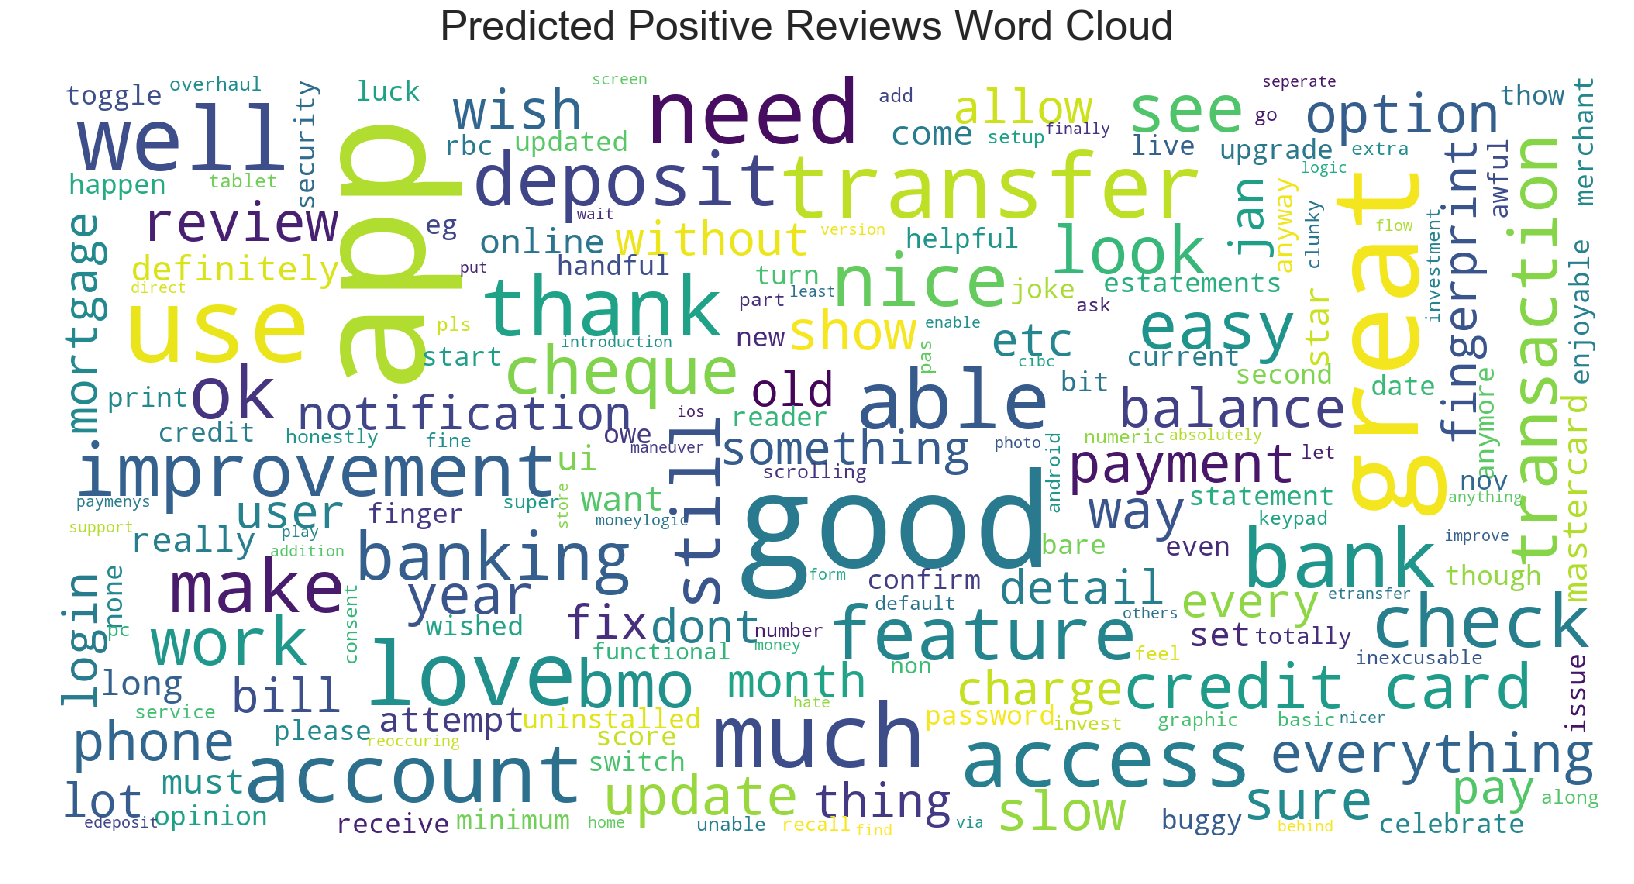

In [47]:
# print wordcloud
wd_title = 'Predicted Positive Reviews Word Cloud'
show_wordcloud(dfn_pred_good['reviews_clean'], title = wd_title)

Negative Review Preview
19611    crash crash crash crash crash crash crash crash crash crash crash crash crash crash crash
17980    hate bad enough rbc bad insurance app get bad                                            
8999     bad bank bad customer service bad rude stuff unprofessional banking dont recommend bank  
23810    wtf wtf wtf cant give no.stars cant even log                                             
12973    app slow hell terrible interface bad banking app far                                     
13122    lame app pretend nfc payment use nfc tool make tap pay app                               
16588    useless app pathetic can't even log-in keep crash                                        
11415    lose thousand dollar horrible webbroker portion app td's response bad sad                
10394    hate hate hate hate hate new update absolutely aweful please roll back old design        
8907     stupid nfc pay feature hurry adopt google pay already                       

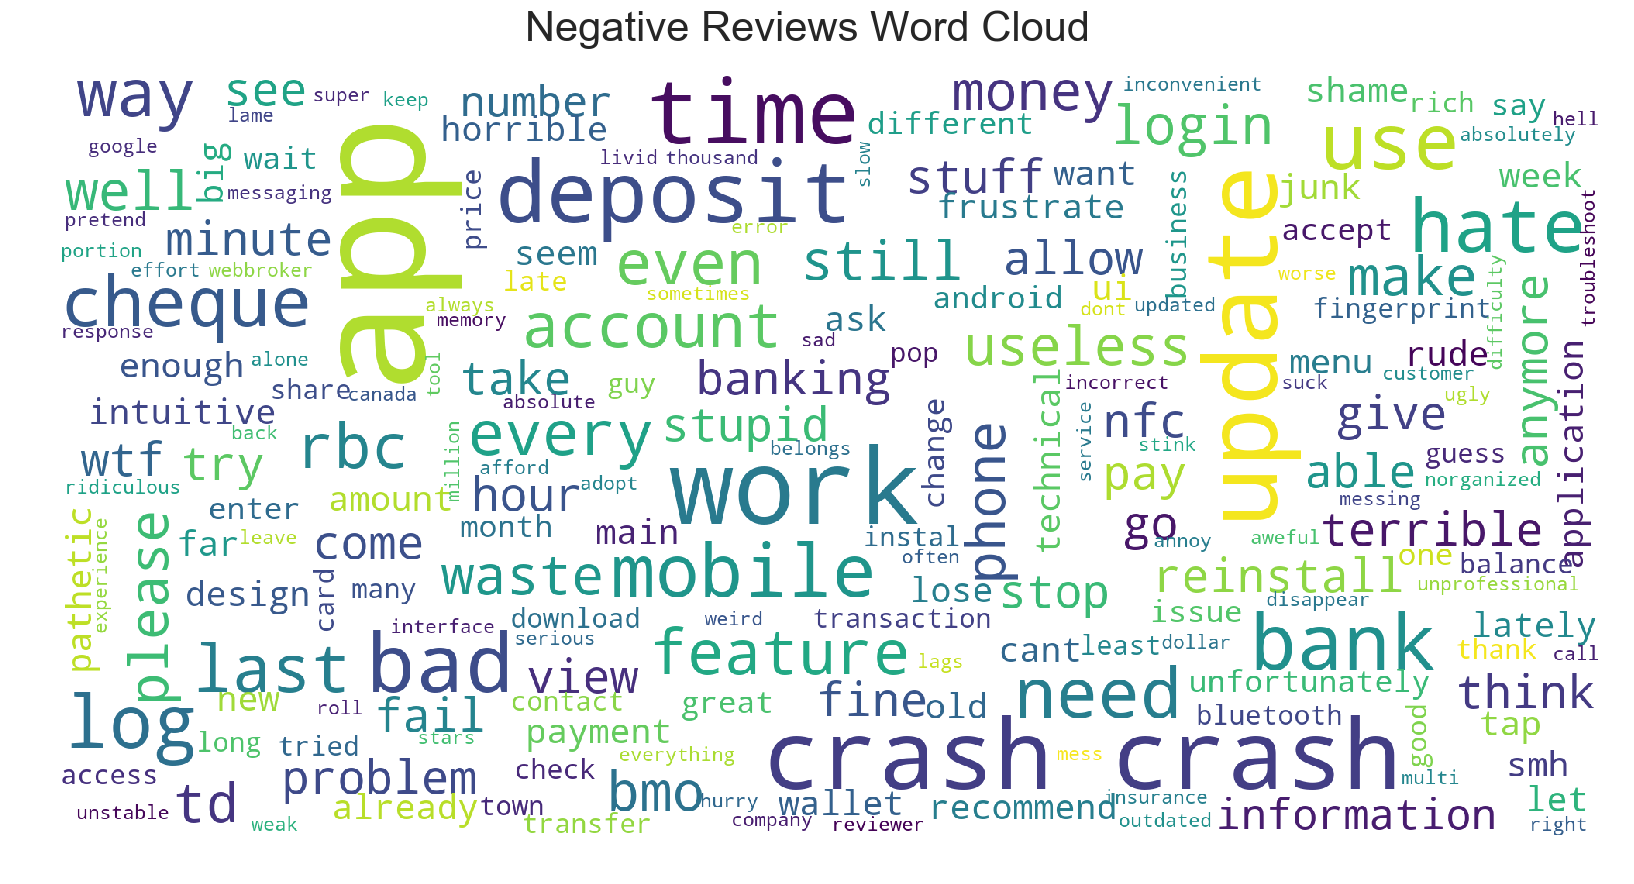

In [56]:
# lowest negative sentiment reviews (with more than 5 words)
df_lowest = df_class[df_class["num_words"] >= 8].sort_values("neg", ascending = False)[["reviews_clean", "neg"]]
print('Negative Review Preview')
print(df_lowest['reviews_clean'].head(10))

# print wordcloud
wd_title = 'Negative Reviews Word Cloud'
show_wordcloud(df_lowest["reviews_clean"], title = wd_title)

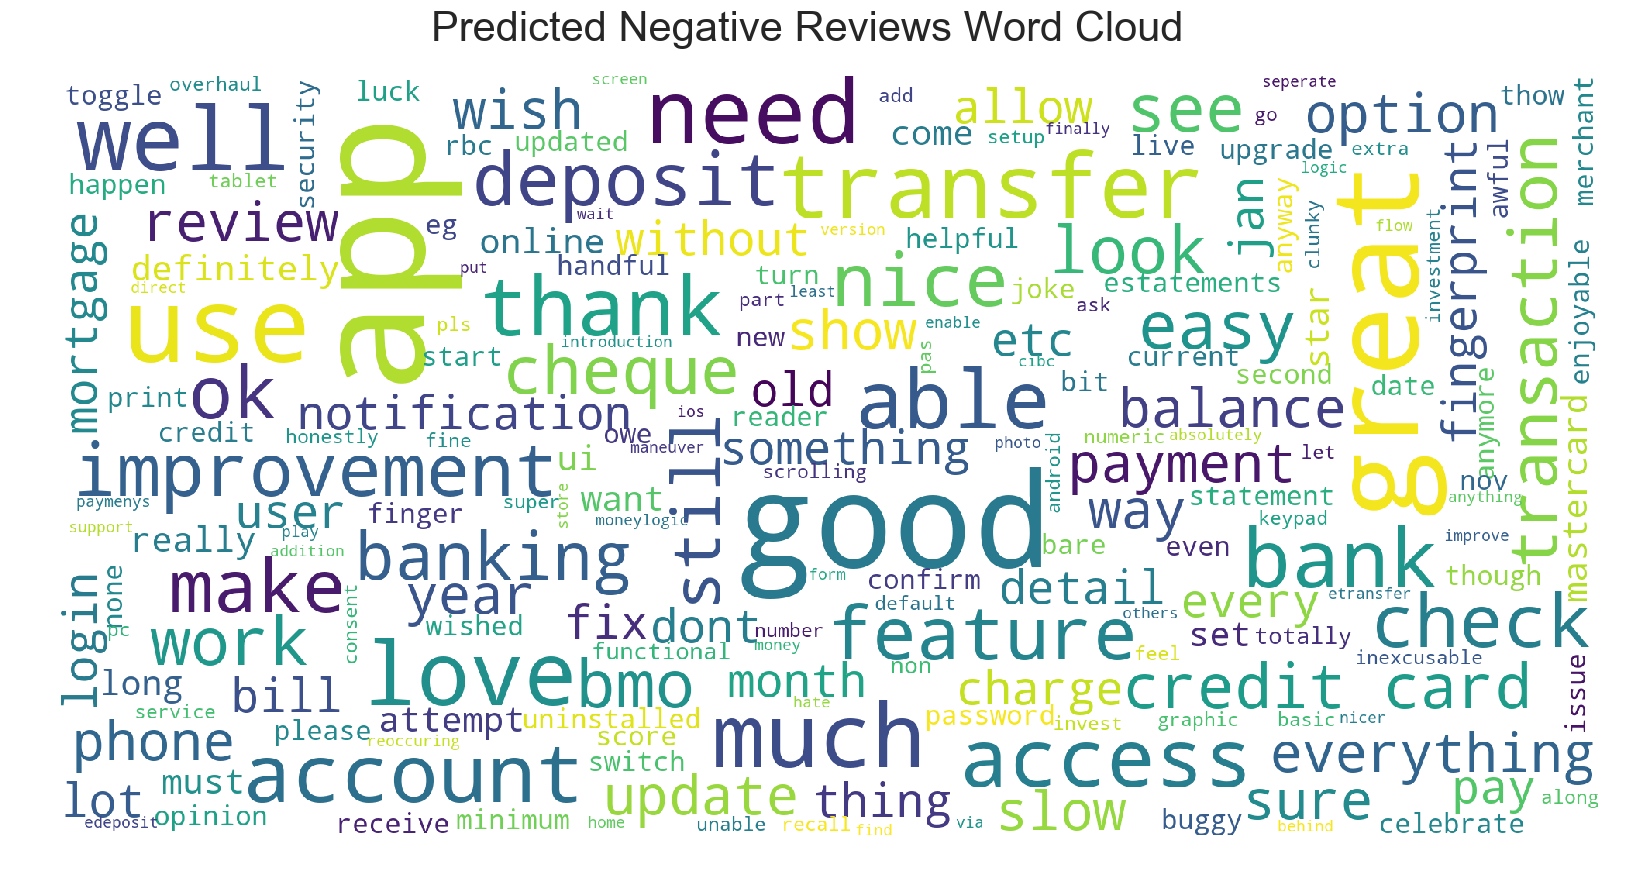

In [49]:
# print wordcloud
wd_title = 'Predicted Negative Reviews Word Cloud'
show_wordcloud(dfn_pred_good['reviews_clean'], title = wd_title)